In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import matplotlib as mpl
import sys
sys.path.append("..")
from exotop.model_1D import the_results as plottop
from exotop.model_1D import inputs as ins
from exotop.model_1D import parameters as p
from exotop.useful_and_bespoke import dark_background, imscatter

# set paths
# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop#
fig_format = '.png'
benchmark_path = '../benchmarks/'

# # set mpl display parameters
# mpl.rcParams['axes.linewidth'] = 2  # set the value globally - for poster
# rc('font',**{'family':'serif','serif':['Times New Roman']})  # latex font for matplotlib CMU Serif Roman
# # rc('font',**{'family':'monospace','monospace':['Ubuntu Mono']})  # for computery poster 
# rc('text', usetex=True)  # turn on for latexy font
# mpl.font_manager._rebuild()
# plt.style.use('dark_background')

/home/claire/anaconda3/lib/python3.7/site-packages/pyshtools/shclasses/shcoeffs.py:622: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  power[0:nl] / (2 * degrees + 1))[_np.newaxis, :, _np.newaxis]
No handles with labels found to put in legend.


IndexError: list index out of range

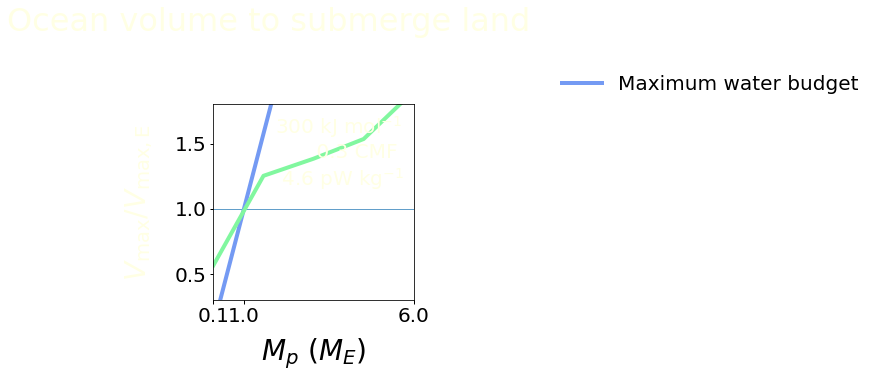

In [2]:
fig, axes = plottop.plot_ocean_capacity_relative(n_stats=10, relative=True, nplanets=5,
                                                 legsize=20, ticksize=20, labelsize=28, wspace=0.15,
                                                 titlesize=32, fig_path=fig_path, save=False,
                                                 showwaterscale=True, log=True,
                                                 defaults='Venusbaseline', textc='xkcd:off white',
                                                 title='Ocean volume to submerge land',
                                                 spectrum_fpath=benchmark_path+'wei_Venus/',
                                                 spectrum_fname='model_power_m2_b.csv',
                                                 c='#81f79f', alpha=1, lw=4, ymin=0.3, ymax=1.8, labelpad=10,
                                                 set_ylim=True, x_vars=['M_p'],
                                                 fname='ocean-vol')

# for ax in axes:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
axes[0].set_ylabel('$V_{\mathrm{max}}/V_{\mathrm{max, E}}$', fontsize=28, c='xkcd:off white', labelpad=20)

axes[0].set_xlim((0.1, 6))
axes[0].set_xticks([0.1, 1, 6])

# axes[1].set_xlim((0.1, 0.5))
# axes[1].set_xticks([0.1, 0.3, 0.5])

# axes[2].set_xlim((10, 40))
# axes[2].set_xticks([10, 25, 40])

# axes[3].set_xlim((250, 350))
# axes[3].set_xticks([300, 350])

fig, *axes = dark_background(fig, axes)

No handles with labels found to put in legend.


TypeError: cannot unpack non-iterable NoneType object

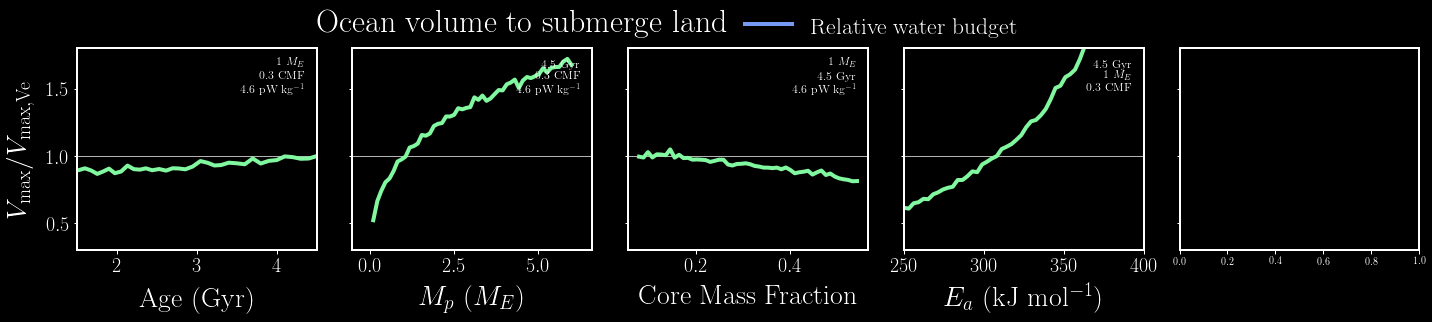

In [2]:
fig, axes = plottop.plot_ocean_capacity_relative(n_stats=100, 
                                                 legsize=23.5, ticksize=20, labelsize=28, wspace=0.15,
                                                 titlesize=32, fig_path=fig_path, save=False,
                                                 defaults='Venusbaseline', 
                                                 title='Ocean volume to submerge land',
                                                 spectrum_fpath=benchmark_path+'wei_Venus/',
                                                 spectrum_fname='model_power_m2_b.csv',
                                                 c='#81f79f', alpha=1, lw=4, ymin=0.3, ymax=1.8, labelpad=10,
                                                 set_ylim=True,
                                                 fname='ocean-vol')